# Batch Effect Investigation

In [4]:
# imports
import os
import glob
import operator
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from functools import reduce
import sys
sys.path.append("../..")
from img_utils import *

letter_dict_rev = {v: k for k, v in letter_dict.items()}
channel_dict_rev = {v: k for k, v in channel_dict.items()}
channel_list = list(channel_dict_rev.values())[:-3]

%matplotlib inline
## Disable truncation globally
# pl.Config.set_tbl_rows(20)  # Show all rows
# pl.Config.set_tbl_cols(40)  # Show all columns

## define control types
TC = ["EGFP"]
NC = ["RHEB", "MAPK9", "PRKACB", "SLIRP"]
PC = ["ALK", "ALK_Arg1275Gln", "PTK2B"]
cNC = ["Renilla"]
cPC = ["KRAS", "PTK2B", "GHSR", "ABL1", "BRD4", "OPRM1", "RB1", "ADA", "WT PMP22", "LYN", "TNF", 
       "CYP2A6", "CSK", "PAK1", "ALDH2", "CHRM3", "KCNQ2", "ALK T1151M", "PRKCE", "LPAR1", "PLP1"]

TRN_IMBAL_THRES = 3
MIN_CLASS_NUM = 2
AUROC_THRESHOLDS = [0.95] ## , 0.99

## 1. Loading QC info

In [2]:
allele_meta_df = pl.DataFrame()
allele_meta_df_dict, img_well_qc_sum_dict = {}, {}

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        allele_meta_df_batch = pl.DataFrame()
        platemaps = [file for file in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)) if file.endswith(".txt")]
        for platemap in platemaps:
            platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
            allele_meta_df_batch = pl.concat([allele_meta_df_batch, 
                                        platemap_df.filter((pl.col("node_type").is_not_null()))], # (~pl.col("node_type").is_in(["TC","NC","PC"]))&
                                        how="diagonal_relaxed").sort("plate_map_name")
            allele_meta_df_batch = allele_meta_df_batch.with_columns(pl.col("plate_map_name").alias("plate_map")) ## str.split('_').list.get(0).
            # display(allele_meta_df.head())
        allele_meta_df = pl.concat([
            allele_meta_df,
            allele_meta_df_batch
        ], how="diagonal_relaxed")#.sort("plate_map_name") ## (~pl.col("node_type").is_in(["TC","NC","PC"]))&
    allele_meta_df_dict[bio_rep] = allele_meta_df_batch

    img_well_qc_sum = pl.read_csv(f"{IMGS_QC_METRICS_DIR}/{bio_rep}/plate-well-level_img_qc_sum.csv")
    img_well_qc_sum = img_well_qc_sum.with_columns(
        pl.col("channel").replace("DAPI", "DNA").alias("channel")
    )
    img_well_qc_sum_morph = img_well_qc_sum.filter(pl.col("channel")!="GFP")
    img_well_qc_sum_morph = img_well_qc_sum_morph.group_by(["plate","well"]).agg(
        pl.col("is_bg").max().alias("is_bg"),
        pl.col("s2n_ratio").mean().alias("s2n_ratio")
    ).with_columns(pl.lit("Morph").alias("channel"))
    img_well_qc_sum = pl.concat([
        img_well_qc_sum.select(pl.col(["plate","well","channel","is_bg","s2n_ratio"])),
        img_well_qc_sum_morph.select(pl.col(["plate","well","channel","is_bg","s2n_ratio"])),
    ], how="vertical_relaxed")
    img_well_qc_sum_dict[bio_rep] = img_well_qc_sum

In [5]:
class_info_dir = "{}/{}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/metrics.csv"
for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        if bio_rep != "2024_12_Batch_11-12":
            batch_id_tmp = batch_id + "_morph"
        class_res_df = pl.read_csv(class_info_dir.format(CLASS_ANALYSES_DIR, batch_id_tmp))
        class_res_df = class_res_df.with_columns(
            pl.when((pl.col("well_0").str.contains(r"(?:01|P|A|24)"))|(pl.col("well_1").str.contains(r"(?:01|P|A|24)")))
            .then(pl.lit(True))
            .otherwise(pl.lit(False))
            .alias("Well_On_Edge")
        )
        # display(class_res_df)
        for channel in channel_list:
            class_res_df_channel = class_res_df.filter(pl.col("Metadata_Feature_Type")==channel)
            class_res_df_channel = class_res_df_channel.join(
                img_well_qc_sum.filter(pl.col("channel")==channel).select(pl.col(["plate","well","is_bg"])),
                left_on=["Plate","well_0"],
                right_on=["plate","well"]
            ).rename({"is_bg": "well_0_is_bg"})
            class_res_df_channel = class_res_df_channel.join(
                img_well_qc_sum.filter(pl.col("channel")==channel).select(pl.col(["plate","well","is_bg"])),
                left_on=["Plate","well_1"],
                right_on=["plate","well"]
            ).rename({"is_bg": "well_1_is_bg"})
            
            plate_maps = sorted(set(["_".join(pm.split("_")[:-1]) for pm in class_res_df_channel["Plate"].unique()]))
            for pm in plate_maps:
                class_res_ch_pm = class_res_df_channel.filter(pl.col("Plate").str.contains(pm))
                plates = sorted(class_res_ch_pm["Plate"].unique().to_list())
                # fig, axes = plt.subplots(2,2,figsize=(48,23)) ## sharey=True,sharex=True
                for plate in plates:
                    plate_info = class_res_ch_pm.filter(pl.col("Plate")==plate)
    
                    ## plot the ctrls alleles first
                    plate_info_ctrl = plate_info.filter(pl.col("Metadata_Control"))
                    ctrls_wells = pl.concat([plate_info_ctrl["well_0"], plate_info_ctrl["well_1"]]).unique()
                    agg_group_by_well_0 = plate_info_ctrl.group_by("well_0","allele_0").agg([
                        pl.col("AUROC").mean().alias("AUROC_Mean"),
                        pl.col("well_0_is_bg").max().alias("is_bg")
                    ]).rename(
                        {"well_0": "well", "allele_0": "allele"}
                    )#.with_columns(pl.col("Well_On_Edge").cast(pl.Boolean).alias("Well_On_Edge"))
                    agg_group_by_well_1 = plate_info_ctrl.filter(
                        (pl.col("well_1").is_in(ctrls_wells))&\
                        (~pl.col("well_1").is_in(agg_group_by_well_0["well"]))
                    ).group_by("well_1","allele_1").agg([
                        pl.col("AUROC").mean().alias("AUROC_Mean"),
                        pl.col("well_1_is_bg").max().alias("is_bg")
                    ]).rename(
                        {"well_1": "well", "allele_1": "allele"}
                    )
                    agg_group_by_well = pl.concat(
                        [
                            agg_group_by_well_0.select(pl.col("well","AUROC_Mean","allele","is_bg")),
                            agg_group_by_well_1.select(pl.col("well","AUROC_Mean","allele","is_bg"))
                        ]
                    )
                    ## plot the auroc per each plate for a platemap
                #     plot_platemap(
                #         agg_group_by_well,
                #         plate+f"_{channel}",
                #         well_pos_col="well",
                #         # this is the column to color by (categorical or continuous)
                #         value_col="AUROC_Mean",
                #         # these columns will be concatenated into the annotation text
                #         label_cols=("allele","AUROC_Mean"),
                #         ax=axes[plates.index(plate)//2, plates.index(plate)%2],
                #         value_type="continuous",   # or "continuous"
                #         continuous_cmap="vlag",  # matplotlib colormap for continuous mode
                #         categorical_colors={True: "tomato", False: "skyblue"},     # dict for categorical → color
                #         grid_square="is_bg"
                #     )
                # fig.subplots_adjust(wspace=-.55, hspace=.05)
                # plt.tight_layout()

In [6]:
metric_df_dict = {}

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        if bio_rep != "2024_12_Batch_11-12":
            batch_id_tmp = batch_id + "_morph"
        else:
            batch_id_tmp = batch_id

        metrics_df = pl.read_csv(class_info_dir.format(CLASS_ANALYSES_DIR, batch_id_tmp))
        batch_id = f"B{batch_id.split('Batch_')[-1]}"
        # display(metrics_df)
        print(f"====================================={batch_id} metrics=====================================")
        metrics_df = metrics_df.with_columns(
            pl.when(pl.col("Metadata_Control"))
            .then(pl.lit("1_Ctrl"))
            .otherwise(pl.lit("2_VAR-WT"))
            .alias("Node_Type"),
            pl.col("Metadata_Feature_Type").alias("Classifier_type"),
            # Extract the substring that:
            #  1. Has a digit (\d) immediately before it (anchors the match at a number)
            #  2. Starts with 'A' and then as few characters as needed (A.*?), captured as group 1
            #  3. Stops right before the literal 'T'
            pl.col("Plate").str.extract(r"\d(A.*?)T", 1).alias("Allele_set"),
            pl.col("Full_Classifier_ID").str.split("_").list.last().alias("Batch")
        )
        metrics_df = metrics_df.join(
            img_well_qc_sum_dict[bio_rep].select(pl.col("plate", "well", "channel", "is_bg")),
            left_on=["Plate", "well_0", "Metadata_Feature_Type"],
            right_on=["plate", "well", "channel"]
        ).rename({"is_bg": "well_0_is_bg"})
        metrics_df = metrics_df.join(
            img_well_qc_sum_dict[bio_rep].select(pl.col("plate", "well", "channel", "is_bg")),
            left_on=["Plate", "well_1", "Metadata_Feature_Type"],
            right_on=["plate", "well", "channel"]
        ).rename({"is_bg": "well_1_is_bg"})
    
        """
            Calculating controls
        """
        metrics_ctrl_df = metrics_df.filter(
            (~pl.col("well_0_is_bg")) & (~pl.col("well_1_is_bg")) & \
            (pl.col("Training_imbalance") < TRN_IMBAL_THRES) & (pl.col("Metadata_Control"))
        )    
        # Filter based on class imbalance
        metrics_ctrl = (
            metrics_ctrl_df
            .select(["Classifier_type", "Batch", "AUROC"])
            .group_by(["Classifier_type", "Batch"])
            .agg([
                pl.col("AUROC").mean().alias("AUROC_mean"),
                pl.col("AUROC").std().alias("AUROC_std")
            ]+[
                pl.col("AUROC").quantile(auroc_thres).alias(f"AUROC_thresh_{auroc_thres*100:.0f}") for auroc_thres in AUROC_THRESHOLDS
            ])
        )
        
        for feat in FEAT_SETS:
            print(f"Total number of control classifiers {feat}:", metrics_ctrl_df.filter((pl.col("Classifier_type") == feat)).shape[0])
            
        print("==========================================================================")
        metric_df_dict[f"{batch_id}_met"] = metrics_df
        # Merge with metrics_df and decide whether it passed the threshold
        metrics_df_thres = metrics_df.join(metrics_ctrl, on=["Classifier_type", "Batch"])
        # print(metrics_df_thres.head())
        metrics_df_thres = metrics_df_thres.with_columns(
            ((pl.col("AUROC") - pl.col("AUROC_mean")) / pl.col("AUROC_std")).alias("AUROC_zscore")
        )
        
        ## Must be at least min_class_num classifiers per batch
        ## Number of classifiers is the same for localization and morph, so just use morph
        classifier_count = (
            metrics_df_thres.filter(
                (~pl.col("Metadata_Control")) & \
                (~pl.col("well_0_is_bg")) & (~pl.col("well_1_is_bg")) & \
                (pl.col("Training_imbalance") < TRN_IMBAL_THRES)
            )
            .group_by(["allele_0", "Allele_set", "Batch", "allele_1"])
            .agg([pl.len().alias("Number_classifiers")])
        )
        classifier_count = classifier_count.pivot(
            index=["allele_0", "allele_1", "Allele_set"],
            on="Batch",
            values="Number_classifiers",
        )
        print(f"Total number of unique classifiers for GFP:", classifier_count.shape[0])
        print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
        print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))
        print("==========================================================================")
    
        # Must be at least min_class_num classifiers per batch
        # Number of classifiers is the same for localization and morph, so just use morph
        classifier_count = (
            metrics_df_thres.filter(
                (pl.col("Training_imbalance") < TRN_IMBAL_THRES)
                & (~pl.col("Metadata_Control"))
                & (pl.col("Classifier_type") == "GFP")
            )
            .group_by(["allele_0", "Allele_set", "Batch", "allele_1"])
            .agg([pl.len().alias("Number_classifiers")])
        )
        classifier_count = classifier_count.pivot(
            index=["allele_0", "allele_1", "Allele_set"],
            on="Batch",
            values="Number_classifiers",
        )
        # display(classifier_count)
        # break
        print(f"After filtering out classifiers with training imbalance > {TRN_IMBAL_THRES}:")
        print("Total number of unique classifiers:", classifier_count.shape)
        print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
        print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))
        print("==========================================================================")
    
        classifier_count = classifier_count.filter(
            (pl.col(batch_id) >= MIN_CLASS_NUM)
        )
        print("After filtering out alleles with available number of classifiers < 2:")
        print("Total number of unique classifiers:", classifier_count.shape)
        print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
        print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))
    
        # filter based on this
        keep_alleles = classifier_count.select("allele_0").to_series().unique().to_list()
        metrics_df_thres = metrics_df_thres.filter(
            ~((~pl.col("Metadata_Control")) & ~pl.col("allele_0").is_in(keep_alleles))
        )
    
        # Filter by imbalance and calculate mean AUROC for each batch
        metrics_wtvar = (
            (
                metrics_df_thres.filter(
                    (~pl.col("well_0_is_bg")) & (~pl.col("well_1_is_bg")) & \
                    (pl.col("Training_imbalance") < TRN_IMBAL_THRES) & (~pl.col("Metadata_Control"))
                )
            )
            .select([
                "AUROC",
                "AUROC_zscore",
                "Classifier_type",
                "Batch",
                "allele_0",
                "trainsize_0",
                "testsize_0",
                "trainsize_1",
                "testsize_1",
                "Allele_set",
                "Training_imbalance",
            ]+[f"AUROC_thresh_{auroc_thres*100:.0f}" for auroc_thres in AUROC_THRESHOLDS])
            .group_by(["Classifier_type", "allele_0", "Allele_set", "Batch"]+[f"AUROC_thresh_{auroc_thres*100:.0f}" for auroc_thres in AUROC_THRESHOLDS]) ## 
            .agg([
                pl.all()
                .exclude(["Classifier_type", "allele_0", "Allele_set", "Batch"]+[f"AUROC_thresh_{auroc_thres*100:.0f}" for auroc_thres in AUROC_THRESHOLDS]) ## 
                .mean()
                .name.suffix("_mean")
            ])
        )
        metric_df_dict[f"{batch_id}_met_thres"] = metrics_df_thres
        metric_df_dict[f"{batch_id}_allele_summary"] = metrics_wtvar

        os.makedirs(f"{CLASS_SUMMARY_DIR}/{bio_rep}/{batch_id_tmp}", exist_ok=True)
        metrics_wtvar.write_csv(f"{CLASS_SUMMARY_DIR}/{bio_rep}/{batch_id_tmp}/metrics_summary.csv")

=====================================B7 metrics=====================================
Total number of control classifiers GFP: 374
Total number of control classifiers DNA: 376
Total number of control classifiers Mito: 376
Total number of control classifiers AGP: 376
Total number of control classifiers Morph: 376
Total number of unique classifiers for GFP: 402
Total number of unique variant alleles: 402
Total number of unique WT genes: 78
After filtering out classifiers with training imbalance > 3:
Total number of unique classifiers: (402, 4)
Total number of unique variant alleles: 402
Total number of unique WT genes: 78
After filtering out alleles with available number of classifiers < 2:
Total number of unique classifiers: (401, 4)
Total number of unique variant alleles: 401
Total number of unique WT genes: 78
=====================================B8 metrics=====================================
Total number of control classifiers GFP: 236
Total number of control classifiers DNA: 228
Tot

In [9]:
batch_id

'B19'

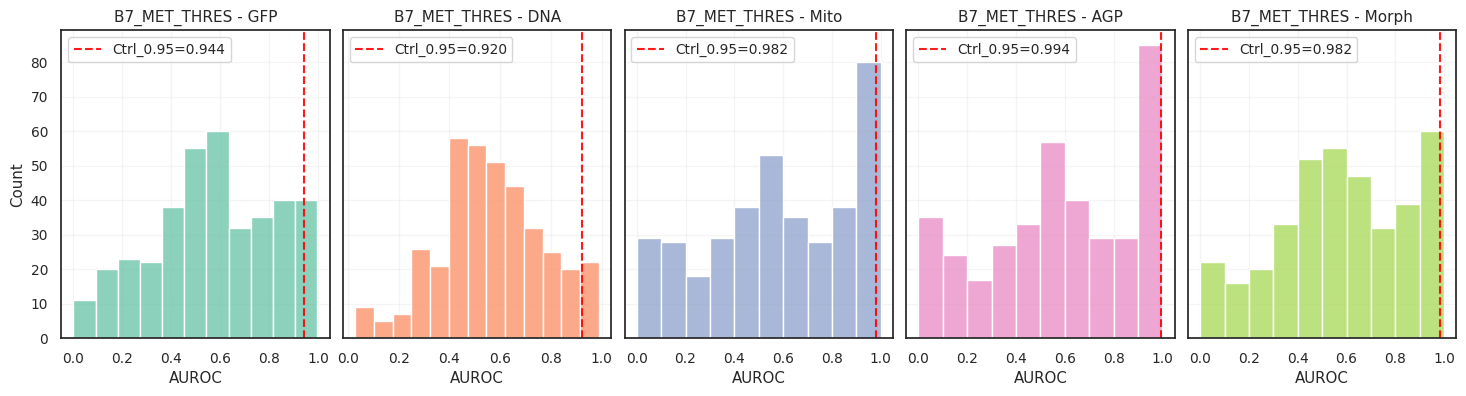

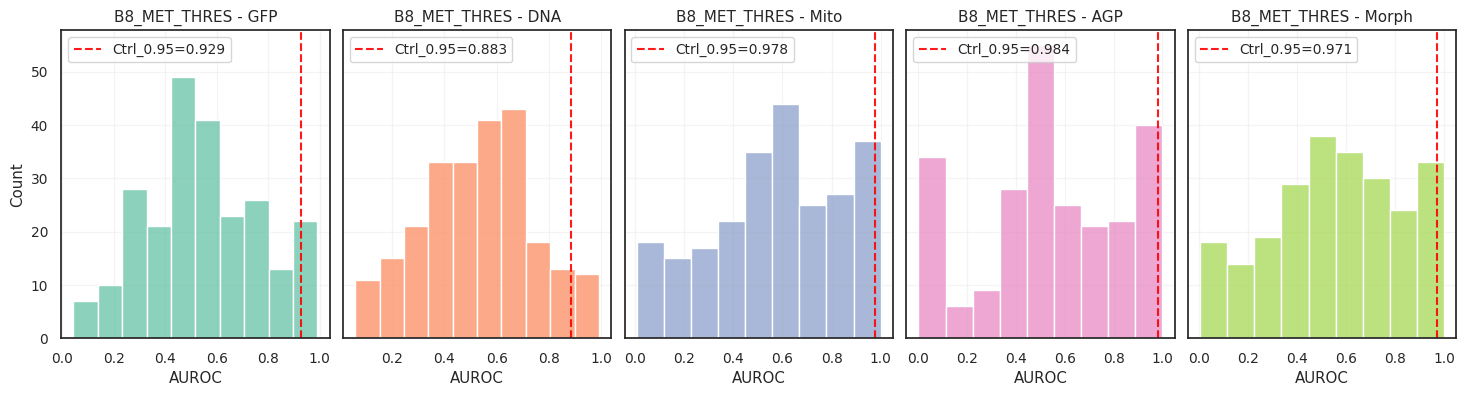

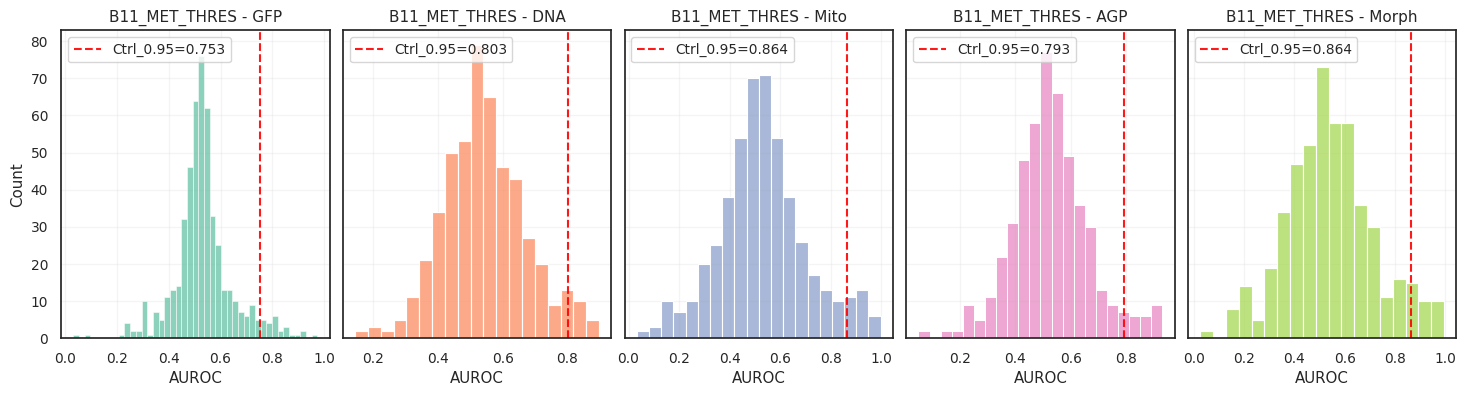

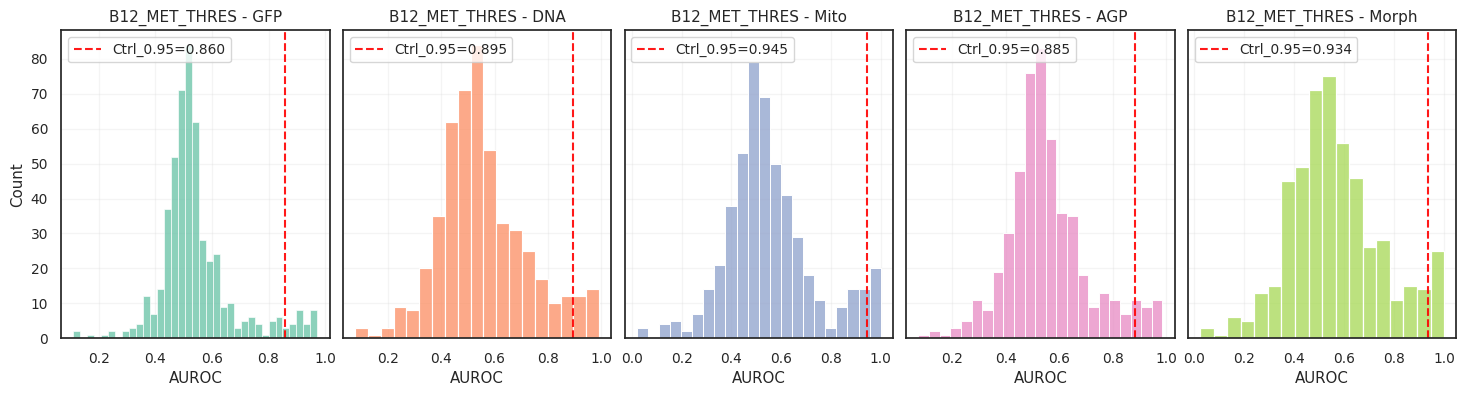

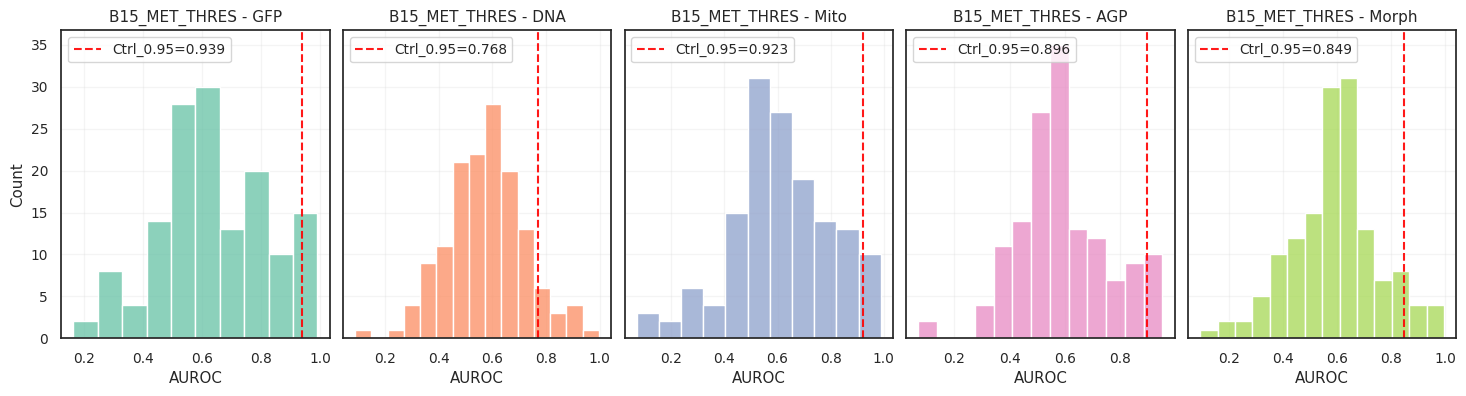

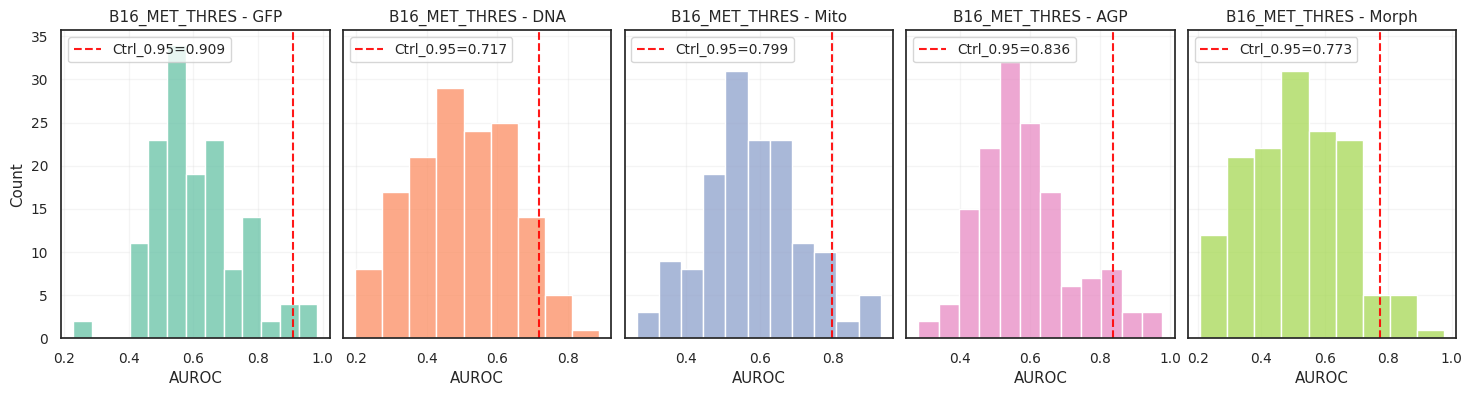

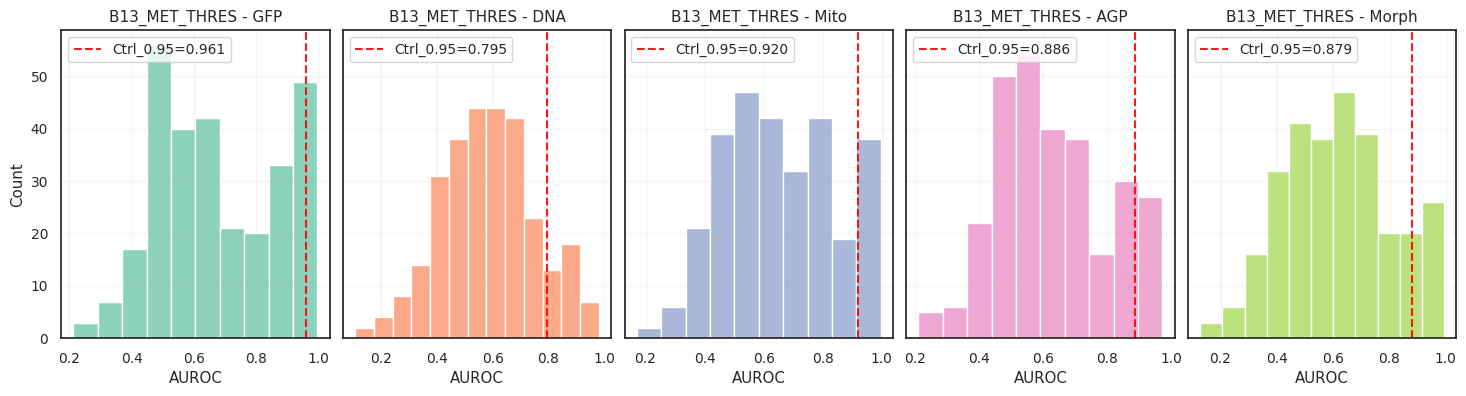

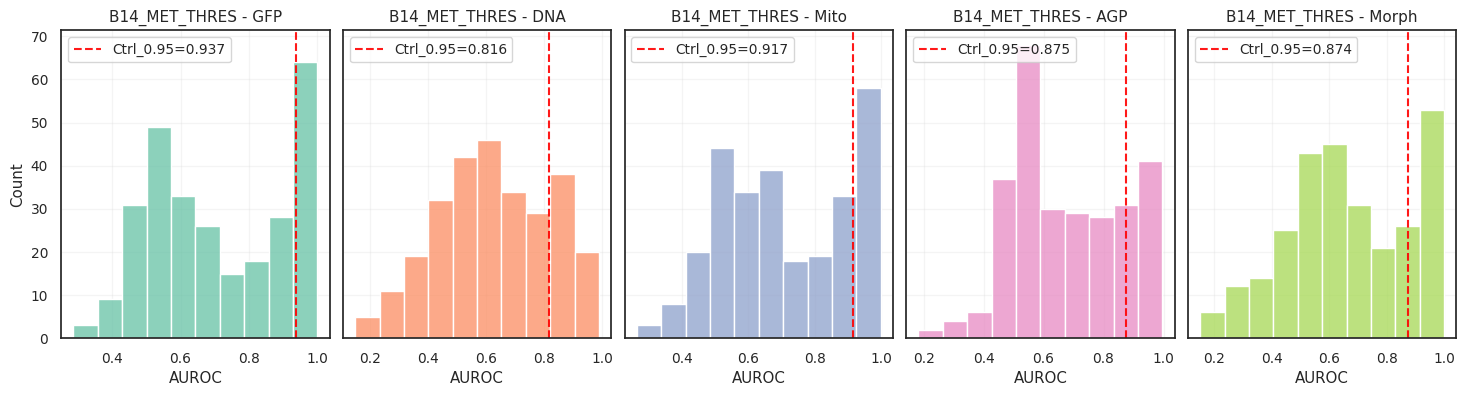

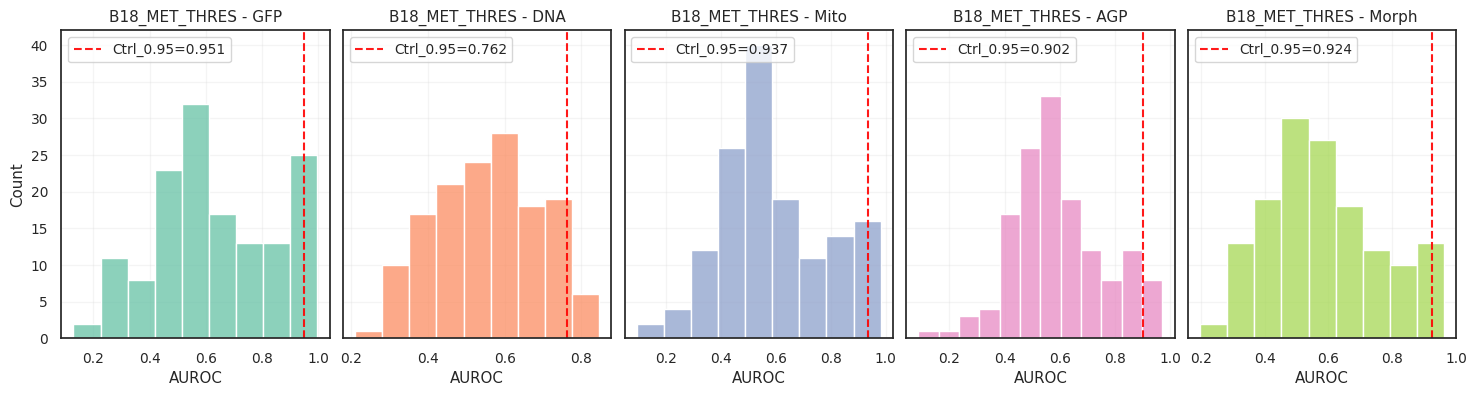

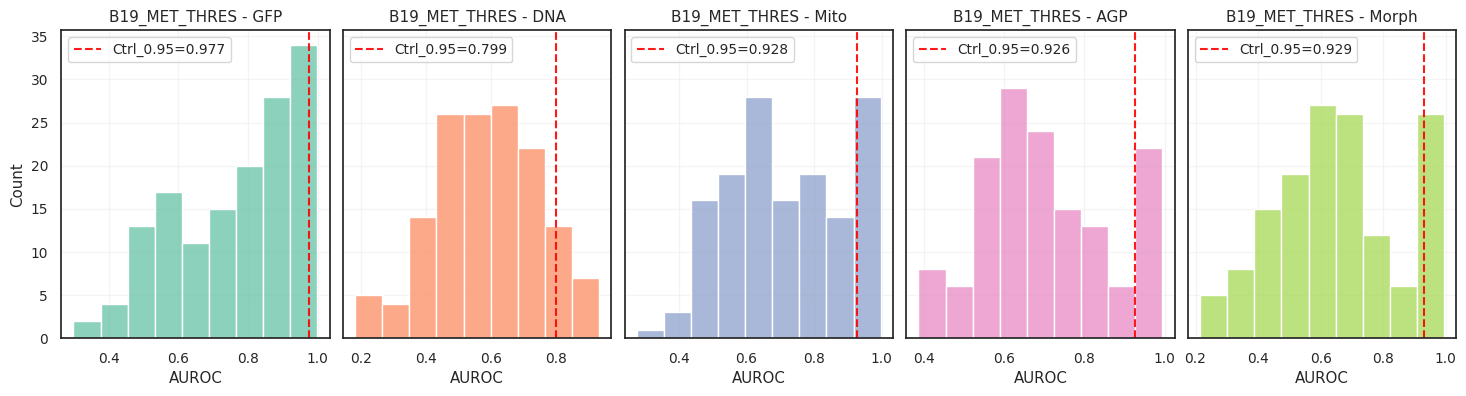

In [27]:
auroc_thres = AUROC_THRESHOLDS[0]
channel_auroc_dict = {}

for key, batch_df in metric_df_dict.items():
    if "_met_thres" in key:
        fig, axes = plt.subplots(1, len(FEAT_SETS), figsize=(18,4), sharey=True)
        for i, feat in enumerate(FEAT_SETS):
            df_feat_ctrl = batch_df.filter(
                pl.col("Classifier_type")==feat,
                pl.col("Metadata_Control")
            )
            if feat not in channel_auroc_dict:
                channel_auroc_dict[feat] = [df_feat_ctrl]
            else:
                channel_auroc_dict[feat].append(df_feat_ctrl)
                
            auroc_val = df_feat_ctrl.filter(pl.col("Metadata_Control")).select(pl.col(f"AUROC_thresh_{auroc_thres*100:.0f}")).to_series().unique().to_list()[0]
            # display(df_feat.filter(pl.col("Classifier_type") == feat).select(f"AUROC_thresh_{auroc_thres*100:.0f}"))
            sns.histplot(
                data=df_feat_ctrl.to_pandas(),
                x="AUROC",
                kde=False,
                ax=axes[i],
                color=sns.color_palette("Set2")[i % len(sns.color_palette("Set2"))]
            )
            # Add vertical lines for thresholds
            colors = ['red', 'purple', 'orange', 'brown']  # Different colors for different thresholds
            axes[i].axvline(auroc_val, color=colors[0], linestyle='--', alpha=0.9, label=f"Ctrl_{auroc_thres}={auroc_val:.3f}")
            # for i, (label, auroc_val) in enumerate(perc_dict.items()):
            #     color = colors[i % len(colors)]
            axes[i].legend(loc="upper left")
            # # Set title and labels
            axes[i].grid(alpha=.2)
            axes[i].set_title(f"{key.upper()} - {feat}", fontsize=11)
             #[f"{batch_id}_met_thres"].filter(pl.col("Metadata_Control"))
        plt.subplots_adjust(wspace=0.05)
        plt.show()

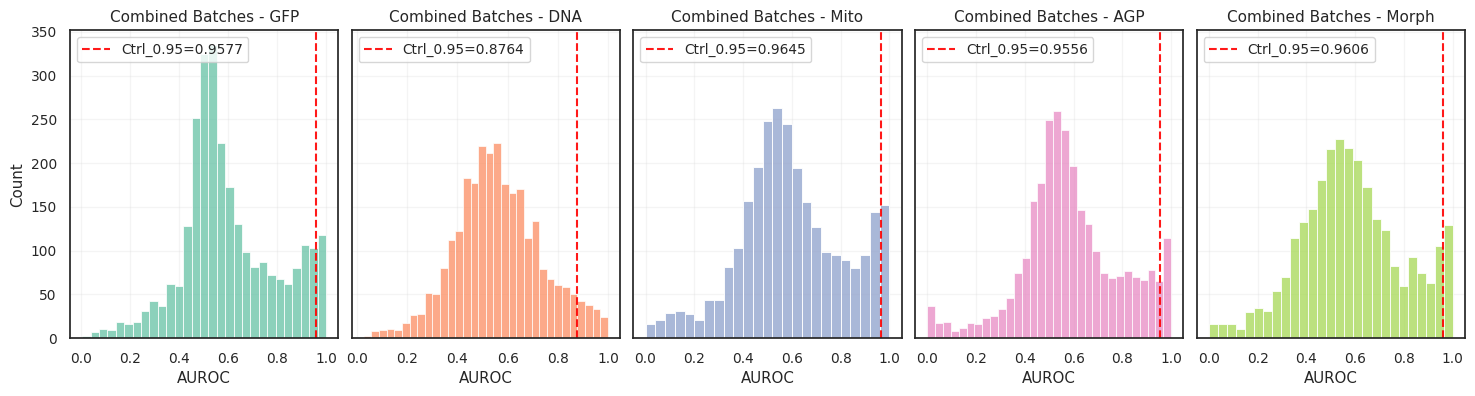

In [ ]:
fig, axes = plt.subplots(1, len(FEAT_SETS), figsize=(18,4), sharey=True)
for i, feat in enumerate(FEAT_SETS):
    combined_df = pl.concat(channel_auroc_dict[feat], how="diagonal_relaxed")
    # display(combined_df)
    sns.histplot(
        data=combined_df.to_pandas(),
        x="AUROC",
        kde=False,
        color=sns.color_palette("Set2")[FEAT_SETS.index(feat) % len(sns.color_palette("Set2"))],
        ax=axes[i]
    )
    auroc_val = combined_df["AUROC"].quantile(auroc_thres)
    # auroc_val = combined_df.filter(pl.col("Metadata_Control")).select(pl.col(f"AUROC_thresh_{auroc_thres*100:.0f}")).to_series().unique().to_list()[0]
    axes[i].axvline(auroc_val, color='red', linestyle='--', alpha=0.9, label=f"Ctrl_{auroc_thres}={auroc_val:.4f}")
    axes[i].legend(loc="upper left")
    axes[i].set_title(f"Combined Batches - {feat}", fontsize=11)
    axes[i].grid(alpha=.2)

plt.subplots_adjust(wspace=0.05)
plt.show()

In [23]:
oneperc_df = pl.read_csv("../outputs/2.classification_results/imaging_analyses_classification_summary_one_perc.csv")
oneperc_df.filter(
    ~pl.col("symbol").is_in(["KCNJ2","STXBP1"])
)

symbol,gene_allele,Metadata_Bio_Batch,Altered_95th_perc_both_batches_GFP,Altered_95th_perc_both_batches_DNA,Altered_95th_perc_both_batches_Mito,Altered_95th_perc_both_batches_AGP,Altered_95th_perc_both_batches_Morph,Altered_99th_perc_both_batches_GFP,Altered_99th_perc_both_batches_DNA,Altered_99th_perc_both_batches_Mito,Altered_99th_perc_both_batches_AGP,Altered_99th_perc_both_batches_Morph,AUROC_Mean_GFP,AUROC_Mean_DNA,AUROC_Mean_Mito,AUROC_Mean_AGP,AUROC_Mean_Morph,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep1_GFP,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_BioRep2_GFP
str,str,str,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""BRAF""","""BRAF_Lys499Asn""","""2025_01_Batch_13-14""",false,false,false,false,false,false,false,false,false,false,0.751505,0.56185,0.725234,0.704712,0.662407,0.663304,0.699625,0.762387,0.54426,0.771352,0.66151,0.709799,0.688081,0.57944,0.731657
"""CTCF""","""CTCF_Tyr407Cys""","""2025_01_Batch_13-14""",false,false,false,false,false,false,false,false,false,false,0.653493,0.587955,0.704138,0.733873,0.645128,0.583208,0.806252,0.657896,0.575567,0.688177,0.707047,0.661494,0.750381,0.600343,0.618809
"""BCL10""","""BCL10_Ala5Ser""","""2025_01_Batch_13-14""",false,false,false,false,false,false,false,false,false,false,0.775557,0.647788,0.767403,0.768018,0.784561,0.800741,0.707529,0.722678,0.754122,0.784466,0.768381,0.828507,0.812128,0.541453,0.766648
"""FARS2""","""FARS2_Asp325Tyr""","""2025_01_Batch_13-14""",false,false,false,false,false,false,false,false,false,false,0.730254,0.68332,0.693254,0.716659,0.716551,0.787532,0.722413,0.680545,0.762253,0.746062,0.64557,0.710905,0.705963,0.604386,0.714446
"""RAD51D""","""RAD51D_Arg55Trp""","""2025_01_Batch_13-14""",false,false,false,false,false,false,false,false,false,false,0.717544,0.547243,0.662655,0.721688,0.55859,0.577305,0.731021,0.661531,0.56697,0.731384,0.539875,0.712355,0.663779,0.527515,0.703705
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""COMP""","""COMP_Cys348Arg""","""2024_01_Batch_7-8""",false,false,false,false,false,false,false,false,false,false,0.878607,0.885403,0.867017,0.781096,0.912494,0.912494,0.853675,0.897148,0.885403,0.923016,null,0.708517,0.836885,null,0.834198
"""GCK""","""GCK_Arg377His""","""2024_01_Batch_7-8""",false,false,false,false,false,false,false,false,false,false,0.759726,0.557682,0.689029,0.702714,0.582422,0.582422,0.702714,0.689029,0.557682,0.759726,null,null,null,null,null
"""GCK""","""GCK_Gly175Arg""","""2024_01_Batch_7-8""",false,false,false,false,false,false,false,false,false,false,0.88123,0.689025,0.835236,0.786208,0.717702,0.717702,0.786208,0.835236,0.689025,0.88123,null,null,null,null,null
